<h1>Assignment-4: Task 2</h1>
Implemented and trained a neural network from scratch using Numpy only, for the MNIST dataset.<br>
The following schema has been followed for the implementation:<br>


 * Loading the MNIST dataset 
 * Implementing the neural network and the stochastic gradient descent algorithm
 * Training and testing the model on the original dataset
 * Testing the same model on the rotated MNIST dataset.

After this, we prepare datasets with some percentage (10%-100%) of the rotated MNIST added to it. We train the model on the same and test them on the following three validation sets:<br>
* `x_test, y_test`: Original testing dataset
* `x_test_mix, y_test_mix`: Original dataset mixed with the rotated dataset
* `x_test_rot, y_test_rot`: Fully rotated MNIST dataset

**Note:** For creating the rotated datasets, a random rotation between -45deg to +45deg is incorporated in the dataset images.

In [33]:
import numpy as np
import h5py
import random
#data file type h5py
import time
import copy
from random import randint
import matplotlib
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from sklearn.utils import shuffle

(10000, 784)


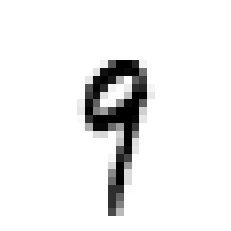

9


In [34]:
#load MNIST data
MNIST_data = h5py.File('MNISTdata.hdf5', 'r')
x_train = np.float32(MNIST_data['x_train'][:])
y_train = np.int32(np.array(MNIST_data['y_train'][:,0]))
x_test = np.float32(MNIST_data['x_test'][:])
y_test = np.int32(np.array(MNIST_data['y_test'][:,0]))
MNIST_data.close()
print(x_test.shape)

# Print a sample dataset
i = 600
plt.imshow(x_train[i,:].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
print(y_train[i])

In [35]:
# preparing the rotated MNIST dataset
print(x_train.shape)
y_test_rotated = y_test
x_test_rotated = np.zeros(x_test.shape)
x_train_rotated = np.zeros(x_train.shape)
y_train_rotated = y_train

for i in range(0,10000):
    r = random.randint(-45,45)
    img = x_test[i,:].reshape(28,28)
    X = ndimage.rotate(img,r, reshape=False)
    x_test_rotated[i,:] = X.reshape(784)
shuffle(x_test_rotated, y_test_rotated);   

for i in range(0,60000):
    r = random.randint(-45,45)
    img = x_train[i,:].reshape(28,28)
    X = ndimage.rotate(img,r, reshape=False)
    x_train_rotated[i,:] = X.reshape(784)
shuffle(x_train_rotated, y_train_rotated)

print(x_train_rotated.shape)


(60000, 784)
(60000, 784)


In [36]:

####################################################################################
#Implementation of stochastic gradient descent algorithm

class NeuralNetwork:
    first_layer = {}
    second_layer = {}

    def __init__(self, inputs, hidden, outputs):
        # initialize the model parameters, including the first and second layer 
        # parameters and biases
        self.first_layer['para'] = np.random.randn(hidden,inputs) / np.sqrt(num_inputs)
        self.first_layer['bias'] = np.random.randn(hidden,1) / np.sqrt(hidden)
        self.second_layer['para'] = np.random.randn(outputs,hidden) / np.sqrt(hidden)
        self.second_layer['bias'] = np.random.randn(outputs,1) / np.sqrt(hidden)
        self.input_size = inputs
        self.hid_size = hidden
        self.output_size = outputs

    def __activfunc(self,Z,type = 'ReLU',deri = False):
        # implement the activation function
        if type == 'ReLU':
            if deri == True:
                return np.array([1 if i>0 else 0 for i in np.squeeze(Z)])
            else:
                return np.array([i if i>0 else 0 for i in np.squeeze(Z)])
        elif type == 'Sigmoid':
            if deri == True:
                return 1/(1+np.exp(-Z))*(1-1/(1+np.exp(-Z)))
            else:
                return 1/(1+np.exp(-Z))
        elif type == 'tanh':
            if deri == True:
                return 
            else:
                return 1-(np.tanh(Z))**2
        else:
            raise TypeError('Invalid type!')

    def __Softmax(self,z):
        # implement the softmax function
        return 1/sum(np.exp(z)) * np.exp(z)

    def __cross_entropy_error(self,v,y):
        # implement the cross entropy error
        return -np.log(v[y])

    def __forward(self,x,y):
        # implement the forward computation, calculation of prediction list and error
        Z = np.matmul(self.first_layer['para'],x).reshape((self.hid_size,1)) + self.first_layer['bias']
        H = np.array(self.__activfunc(Z)).reshape((self.hid_size,1))
        U = np.matmul(self.second_layer['para'],H).reshape((self.output_size,1)) + self.second_layer['bias']
        predict_list = np.squeeze(self.__Softmax(U))
        error = self.__cross_entropy_error(predict_list,y)
        
        dic = {
            'Z':Z,
            'H':H,
            'U':U,
            'f_X':predict_list.reshape((1,self.output_size)),
            'error':error
        }
        return dic

    def __back_propagation(self,x,y,f_result):
        # implement the back propagation process, compute the gradients
        E = np.array([0]*self.output_size).reshape((1,self.output_size))
        E[0][y] = 1
        dU = (-(E - f_result['f_X'])).reshape((self.output_size,1))
        db_2 = copy.copy(dU)
        dC = np.matmul(dU,f_result['H'].transpose())
        delta = np.matmul(self.second_layer['para'].transpose(),dU)
        db_1 = delta.reshape(self.hid_size,1)*self.__activfunc(f_result['Z'],deri=True).reshape(self.hid_size,1)
        dW = np.matmul(db_1.reshape((self.hid_size,1)),x.reshape((1,784)))

        grad = {
            'dC':dC,
            'db_2':db_2,
            'db_1':db_1,
            'dW':dW
        }
        return grad

    def __optimize(self,b_result, learning_rate):
        # update the hyperparameters
        self.second_layer['para'] -= learning_rate*b_result['dC']
        self.second_layer['bias'] -= learning_rate*b_result['db_2']
        self.first_layer['bias'] -= learning_rate*b_result['db_1']
        self.first_layer['para'] -= learning_rate*b_result['dW']

    def __loss(self,X_train,Y_train):
        # implement the loss function of the training set
        loss = 0
        for n in range(len(X_train)):
            y = Y_train[n]
            x = X_train[n][:]
            loss += self.__forward(x,y)['error']
        return loss

    def train(self, X_train, Y_train, num_iterations = 1000, learning_rate = 0.5):
        # generate a random list of indices for the training set
        rand_indices = np.random.choice(len(X_train), num_iterations, replace=True)
        
        def l_rate(base_rate, ite, num_iterations, schedule = False):
        # determine whether to use the learning schedule
            if schedule == True:
                return base_rate * 10 ** (-np.floor(ite/num_iterations*5))
            else:
                return base_rate

        count = 1
        loss_dict = {}
        test_dict = {}

        for i in rand_indices:
            f_result = self.__forward(X_train[i],Y_train[i])
            b_result = self.__back_propagation(X_train[i],Y_train[i],f_result)
            self.__optimize(b_result,l_rate(learning_rate,i,num_iterations,True))
            
            if count % 1000 == 0:
                if count % 5000 == 0:
                    loss = self.__loss(X_train,Y_train)
                    test = self.testing(x_test,y_test)
                    print('Trained for {} times,'.format(count),'loss = {}, test = {}'.format(loss,test))
                    loss_dict[str(count)]=loss
                    test_dict[str(count)]=test
                else:
                    print('Trained for {} times,'.format(count))
            count += 1

        print('Training finished!')
        return loss_dict, test_dict

    def testing(self,X_test, Y_test):
        # test the model on the training dataset
        total_correct = 0
        for n in range(len(X_test)):
            y = Y_test[n]
            x = X_test[n][:]
            prediction = np.argmax(self.__forward(x,y)['f_X'])
            if (prediction == y):
                total_correct += 1
        print('Accuarcy Test: ',(total_correct/len(X_test)))
        return total_correct/np.float32(len(X_test))


**Testing the model on our original dataset**

Trained for 1000 times,
Trained for 2000 times,
Trained for 3000 times,
Trained for 4000 times,
Accuarcy Test:  0.6759
Trained for 5000 times, loss = 64157.34530092556, test = 0.6759
Trained for 6000 times,
Trained for 7000 times,
Trained for 8000 times,
Trained for 9000 times,
Accuarcy Test:  0.8032
Trained for 10000 times, loss = 41331.764990677984, test = 0.8032
Trained for 11000 times,
Trained for 12000 times,
Trained for 13000 times,
Trained for 14000 times,
Accuarcy Test:  0.8354
Trained for 15000 times, loss = 35111.151341409735, test = 0.8354
Trained for 16000 times,
Trained for 17000 times,
Trained for 18000 times,
Trained for 19000 times,
Accuarcy Test:  0.8632
Trained for 20000 times, loss = 30010.642919047583, test = 0.8632
Training finished!
Accuarcy Test:  0.8632


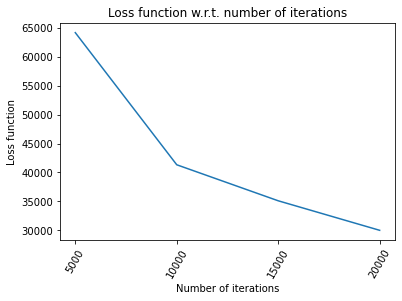

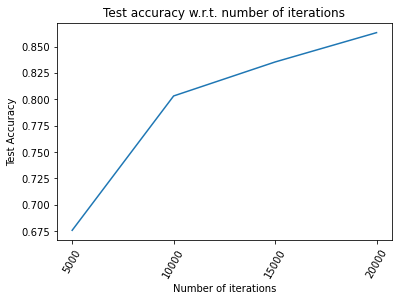

In [37]:
# set the number of iterations
num_iterations = 20000
# set the base learning rate
learning_rate = 0.01
# number of inputs
num_inputs = 28*28
# number of outputs
num_outputs = 10
# size of hidden layer
hidden_size = 300

# data fitting, training and accuracy evaluation
model = NeuralNetwork(num_inputs,hidden_size,num_outputs)
cost_dict, tests_dict = model.train(x_train,y_train,num_iterations=num_iterations,learning_rate=learning_rate)

# testing for the original dataset
accu = model.testing(x_test,y_test)
# plotting the loss function and test accuracy corresponding to the number of iterations
plt.plot(cost_dict.keys(),cost_dict.values())
plt.ylabel('Loss function')
plt.xlabel('Number of iterations')
plt.xticks(rotation=60)
plt.title('Loss function w.r.t. number of iterations')
plt.show()

plt.plot(tests_dict.keys(),tests_dict.values())
plt.ylabel('Test Accuracy')
plt.xlabel('Number of iterations')
plt.xticks(rotation=60)
plt.title('Test accuracy w.r.t. number of iterations')
plt.show()


**Testing for the Rotated MNIST dataset without training**

Accuarcy Test:  0.6243


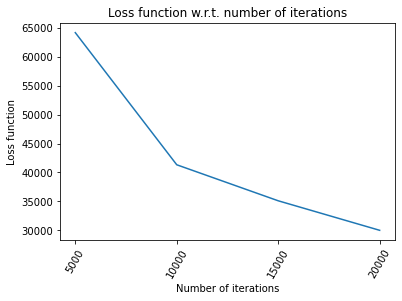

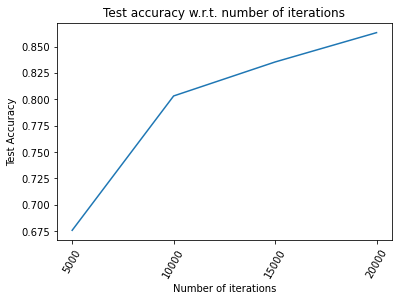

In [38]:
accu = model.testing(x_test_rotated,y_test_rotated)
# plotting the loss function and test accuracy corresponding to the number of iterations
plt.plot(cost_dict.keys(),cost_dict.values())
plt.ylabel('Loss function')
plt.xlabel('Number of iterations')
plt.xticks(rotation=60)
plt.title('Loss function w.r.t. number of iterations')
plt.show()

plt.plot(tests_dict.keys(),tests_dict.values())
plt.ylabel('Test Accuracy')
plt.xlabel('Number of iterations')
plt.xticks(rotation=60)
plt.title('Test accuracy w.r.t. number of iterations')
plt.show()


<h1>Training with added roated datasets</h1>

In [39]:
accuracyOnOriginal = np.zeros(10)
accuracyOnMix = np.zeros(10)
accuracyOnRot = np.zeros(10)

# Creating the mix testing dataset
x_test_mix = x_test
y_test_mix = y_test
x_test_mix[5000:,:] = x_test_rotated[5000,:]
shuffle(x_test_mix,y_test_mix)

for i in range(0,10):

    # preparing rotated datasets
    start = 0
    end = start+6000*(i+1)
    x_train_rot = x_train
    y_train_rot = y_train

    x_rot_add = x_train_rotated[start:end,:]
    y_rot_add = y_train_rotated[start:end]
    x_train_rot = np.append(x_train,x_rot_add, axis=0)
    y_train_rot = np.append(y_train,y_rot_add)
    shuffle(x_train_rot, y_train_rot)
    x = (i+1)*10
    print("Training on dataset with %2d%% of rotated dataset added to the orginal MNIST" % x)

    # data fitting, training and accuracy evaluation
    model = NeuralNetwork(num_inputs,hidden_size,num_outputs)
    cost_dict, tests_dict = model.train(x_train_rot,y_train_rot,num_iterations=num_iterations,learning_rate=learning_rate)


    accuracyOnOriginal[i] = model.testing(x_test,y_test)
    accuracyOnMix[i] = model.testing(x_test_mix,y_test_mix)
    accuracyOnRot[i] = model.testing(x_test_rotated, y_test_rotated)




Training on dataset with 10% of rotated dataset added to the orginal MNIST
Trained for 1000 times,
Trained for 2000 times,
Trained for 3000 times,
Trained for 4000 times,
Accuarcy Test:  0.377
Trained for 5000 times, loss = 69007.25231194582, test = 0.377
Trained for 6000 times,
Trained for 7000 times,
Trained for 8000 times,
Trained for 9000 times,
Accuarcy Test:  0.4217
Trained for 10000 times, loss = 47796.229529584205, test = 0.4217
Trained for 11000 times,
Trained for 12000 times,
Trained for 13000 times,
Trained for 14000 times,
Accuarcy Test:  0.4487
Trained for 15000 times, loss = 42819.51705053845, test = 0.4487
Trained for 16000 times,
Trained for 17000 times,
Trained for 18000 times,
Trained for 19000 times,
Accuarcy Test:  0.4692
Trained for 20000 times, loss = 35600.26857282111, test = 0.4692
Training finished!
Accuarcy Test:  0.4692
Accuarcy Test:  0.4692
Accuarcy Test:  0.6371
Training on dataset with 20% of rotated dataset added to the orginal MNIST
Trained for 1000 tim

[ 10  20  30  40  50  60  70  80  90 100]


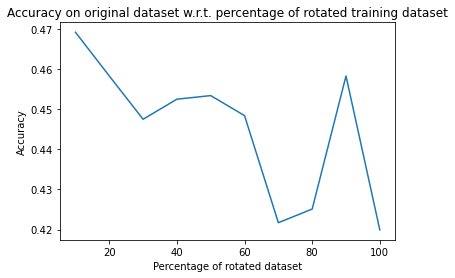

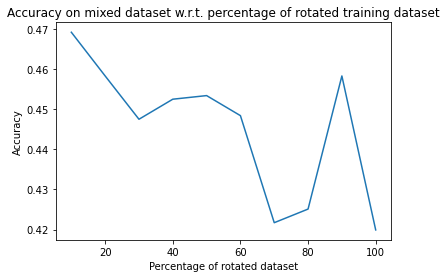

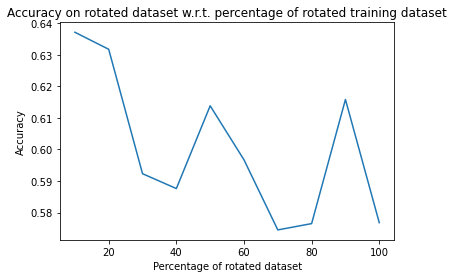

In [40]:
x = np.arange(1,11)
x = x*10
print(x)

plt.plot(x,accuracyOnOriginal)
plt.ylabel('Accuracy')
plt.xlabel('Percentage of rotated dataset')
plt.title('Accuracy on original dataset w.r.t. percentage of rotated training dataset')
plt.show()

plt.plot(x,accuracyOnMix)
plt.ylabel('Accuracy')
plt.xlabel('Percentage of rotated dataset')
plt.title('Accuracy on mixed dataset w.r.t. percentage of rotated training dataset')
plt.show()

plt.plot(x,accuracyOnRot)
plt.ylabel('Accuracy')
plt.xlabel('Percentage of rotated dataset')
plt.title('Accuracy on rotated dataset w.r.t. percentage of rotated training dataset')
plt.show()

